In [4]:
import pandas as pd
import numpy as np
import sklearn
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.utils import to_time_series_dataset

In [5]:
trainX = pd.read_csv("data/X_train.csv").drop(columns=["id"])
trainy = pd.read_csv("data/y_train.csv").drop(columns=["id"])
testX = pd.read_csv("data/X_test.csv").drop(columns=["id"])

In [6]:
print(trainX.info())
trainX.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5117 entries, 0 to 5116
Columns: 17842 entries, x0 to x17841
dtypes: float64(15352), int64(2490)
memory usage: 696.5 MB
None


x0   x1   x2   x3   x4   x5   x6   x7   x8   x9  ...  x17832  x17833  \
0  -64  -66  -69  -72  -75  -77  -80  -86  -89  -83  ...     NaN     NaN   
1  505  500  496  492  487  480  475  476  483  495  ...     NaN     NaN   
2  -21  -16  -12   -7   -3    0    1    2    4    5  ...     NaN     NaN   
3 -211 -457 -635 -710 -715 -663 -573 -481 -401 -337  ...     NaN     NaN   
4   36   32   29   25   22   19   17   15   12   10  ...     NaN     NaN   

   x17834  x17835  x17836  x17837  x17838  x17839  x17840  x17841  
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
4     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[5 rows x 17842 columns]

In [7]:
# find the lengths of the samplings
notNan = pd.DataFrame(trainX.count(axis=1))
print(notNan.describe(), "\n")
print(notNan[0])
# At minimum 2490 time frames are filled, at maximum 17841 time frames

# Idea : We can cut each sampling into parts if they are periodic

                  0
count   5117.000000
mean    9042.773500
std     3084.972324
min     2490.000000
25%     8140.000000
50%     8370.000000
75%     8629.000000
max    17841.000000 

0       16279
1        8679
2        8107
3        8128
4        8360
        ...  
5112     5192
5113     8528
5114     8090
5115     8438
5116     8535
Name: 0, Length: 5117, dtype: int64


# Searching for Periodicity

In [5]:
minIdx = notNan.idxmin()
print(minIdx)

0    2384
dtype: int64


<AxesSubplot:>

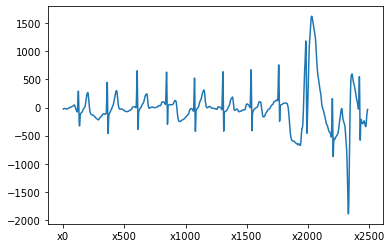

In [6]:
trainX.iloc[2384,:].plot()
# There is a periodicity!!

y    0
Name: 2327, dtype: int64


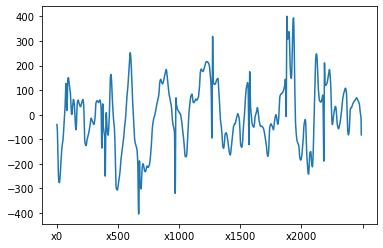

y    2
Name: 4938, dtype: int64


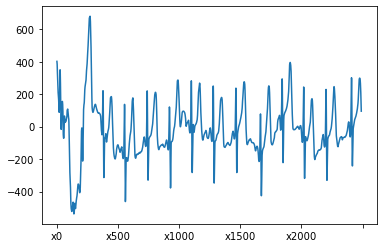

y    1
Name: 2806, dtype: int64


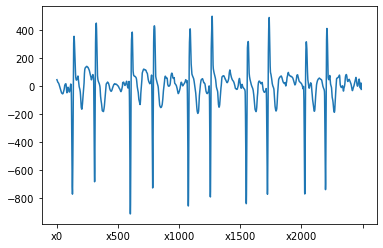

y    0
Name: 1731, dtype: int64


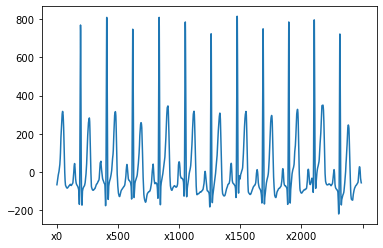

y    1
Name: 4238, dtype: int64


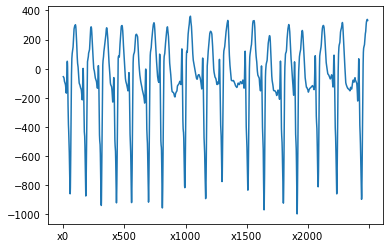

y    2
Name: 3347, dtype: int64


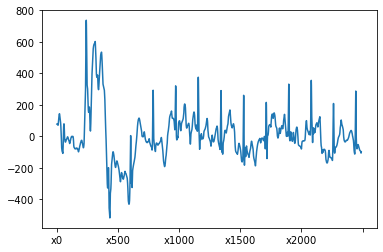

y    1
Name: 2060, dtype: int64


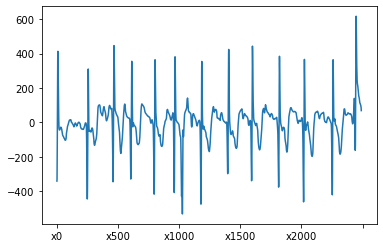

y    2
Name: 1811, dtype: int64


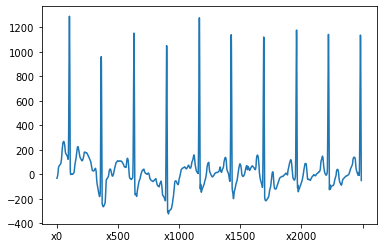

y    0
Name: 3748, dtype: int64


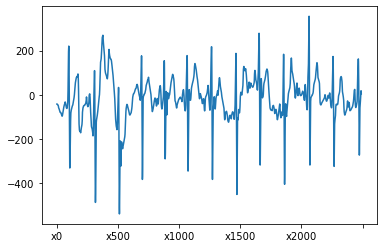

y    3
Name: 4021, dtype: int64


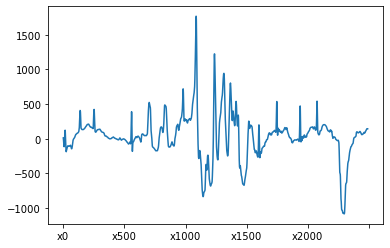

In [7]:
import random
# Trying out random datapoints...
for i in range(0,10):
    x = random.randint(0,5100)
    trainX.iloc[x,0:2490].plot()
    print(trainy.iloc[x,:])
    plt.show()
# There is periodicty indeed

# Idea : We can standard scale the data and take the points with high amplitude as starting points of the period

In [8]:
from sklearn.preprocessing import StandardScaler

transposed = trainX.T
for i in range(0,len(transposed.T)):
    maxVal = transposed.iloc[:,i].max()
    minVal = transposed.iloc[:,i].min()
    transposed.iloc[:,i] = (transposed.iloc[:,i] - minVal)/(maxVal-minVal)
scaledTrainX = transposed.T

y    0
Name: 3468, dtype: int64


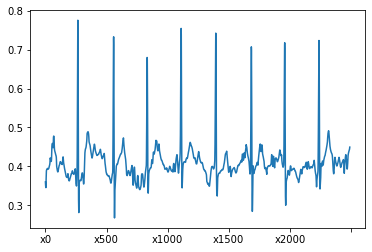

y    0
Name: 414, dtype: int64


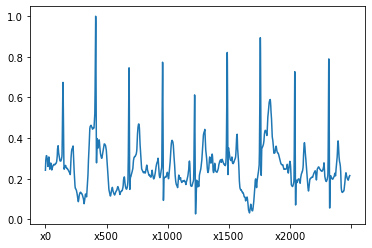

y    0
Name: 2247, dtype: int64


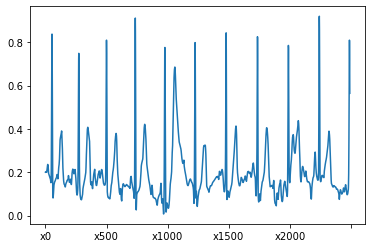

y    0
Name: 1711, dtype: int64


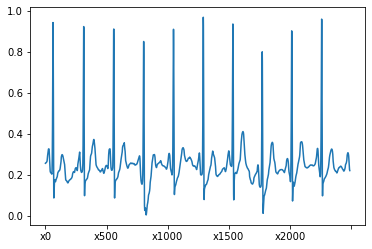

y    2
Name: 3079, dtype: int64


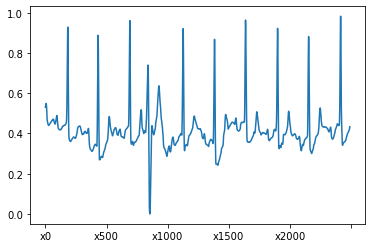

y    0
Name: 4022, dtype: int64


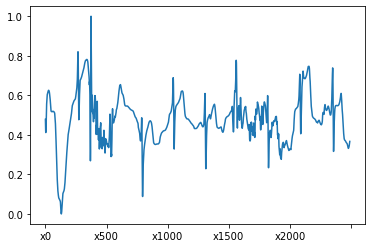

y    0
Name: 2750, dtype: int64


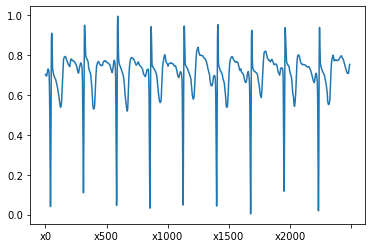

y    0
Name: 3948, dtype: int64


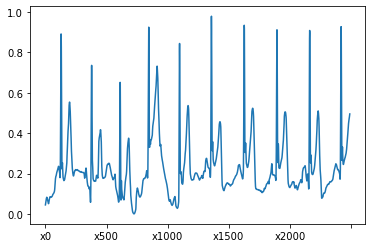

y    0
Name: 4063, dtype: int64


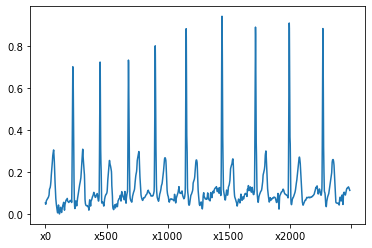

y    0
Name: 3788, dtype: int64


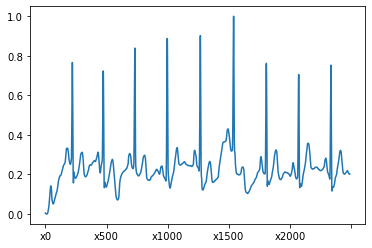

In [9]:
for i in range(0,10):
    x = random.randint(0,5100)
    scaledTrainX.iloc[x,0:2490].plot()
    print(trainy.iloc[x,:])
    plt.show()

# Idea : Since we have 2490 time frames at minimum, we can quickly see the training results by training on them

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score , make_scorer

f1 = make_scorer(f1_score,average="micro")

randomForest = RandomForestClassifier()

In [ ]:
# Using the first 2000 time frames
print(cross_val_score(randomForest, trainX.iloc[:,0:2000], trainy.values.ravel(), cv=5, scoring=f1))
# The f1 score is around 0.58 for raw data
print(cross_val_score(randomForest, scaledTrainX.iloc[:,0:2000], trainy.values.ravel(), cv=5, scoring=f1))
# The f1 score is around 0.58 for scaled data

# Idea : Pass the data through a Bandpass 

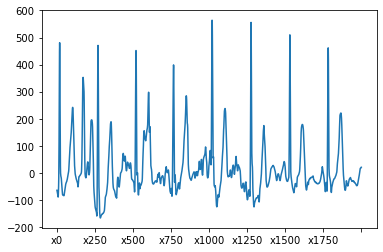

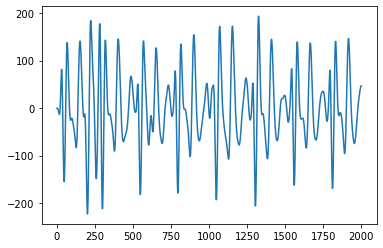

In [10]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

trainX.iloc[0,0:2000].plot()
plt.show()
bandPassed = []
for i in range(0,len(trainX)):
    bandPassed.append(butter_bandpass_filter(trainX.iloc[i,0:2000],lowcut=3,highcut=10,fs=300,order=4))
plt.plot(bandPassed[0])
plt.show()

In [ ]:
print(cross_val_score(randomForest, bandPassed, trainy.values.ravel(), cv=5, scoring=f1))
# The result doesn't really change

# Idea : Fill NaN values with zeros

In [11]:
filledWithZero = trainX.fillna(0)
print(filledWithZero.isnull().values.any())

False


In [16]:
print(cross_val_score(randomForest, filledWithZero.iloc[:,0:8000], trainy.values.ravel(), cv=5, scoring=f1))
# The result is around 0.58

[0.59277344 0.59375    0.58357771 0.59139785 0.59139785]


# Transforming the data using neurokit2

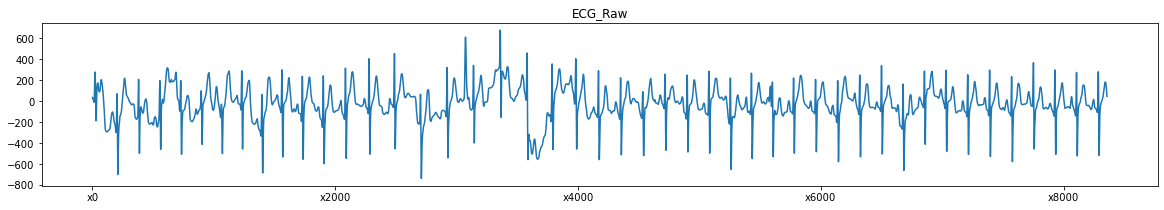

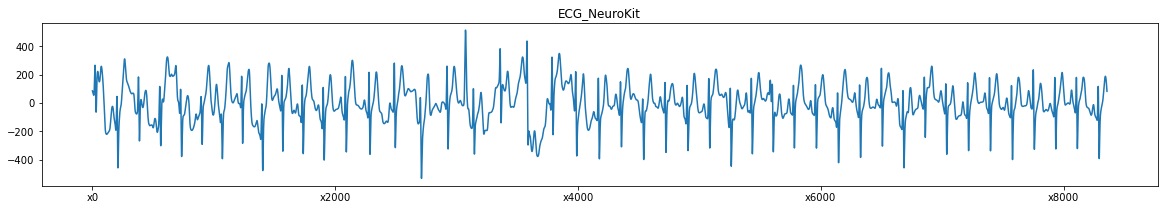

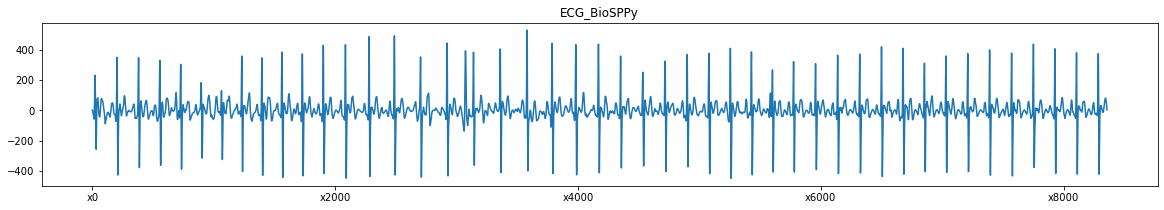

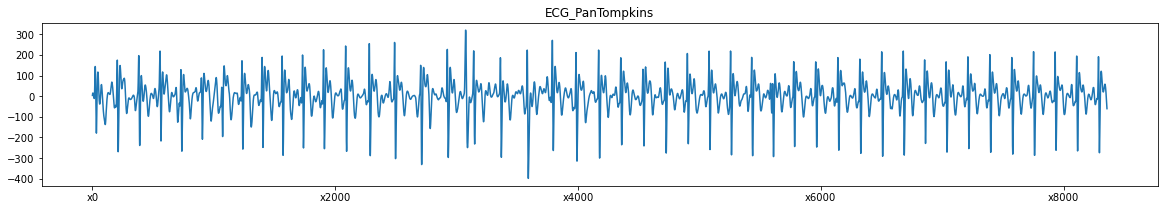

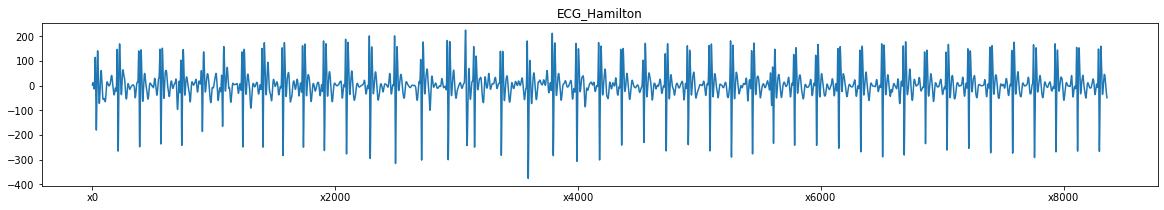

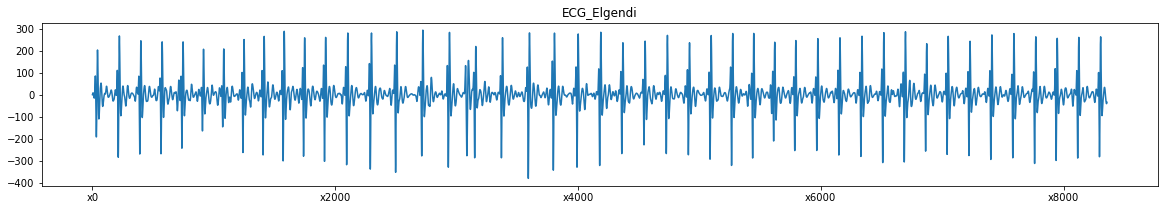

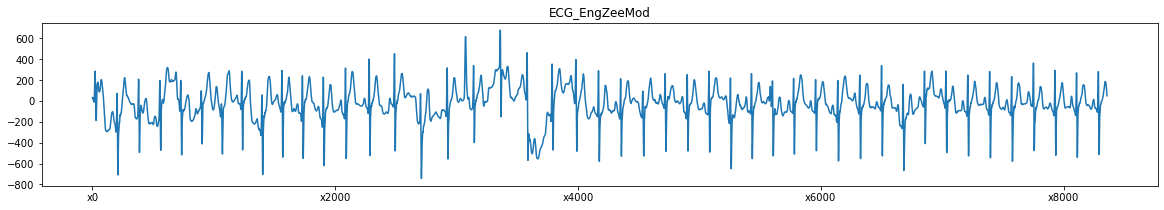

2


In [8]:
import neurokit2 as nk
trainX.iloc[31,0:8359].plot(figsize=(20,3))
plt.show()
#print(trainX.iloc[0,0:16278].isnull().values.any())
signals = pd.DataFrame({"ECG_Raw" : trainX.iloc[4,0:8359],
                        "ECG_NeuroKit" : nk.ecg_clean(trainX.iloc[4,0:8359], sampling_rate=300, method="neurokit"),
                        "ECG_BioSPPy" : nk.ecg_clean(trainX.iloc[4,0:8359], sampling_rate=300, method="biosppy"),
                        "ECG_PanTompkins" : nk.ecg_clean(trainX.iloc[4,0:8359], sampling_rate=300, method="pantompkins1985"),
                        "ECG_Hamilton" : nk.ecg_clean(trainX.iloc[4,0:8359], sampling_rate=300, method="hamilton2002"),
                        "ECG_Elgendi" : nk.ecg_clean(trainX.iloc[4,0:8359], sampling_rate=300, method="elgendi2010"),
                        "ECG_EngZeeMod" : nk.ecg_clean(trainX.iloc[4,0:8359], sampling_rate=300, method="engzeemod2012")})
for i in range (0,len(signals.T)):
    signals.iloc[:,i].plot(figsize=(20,3), title=signals.columns[i])
    plt.show()
print(trainy["y"][4])

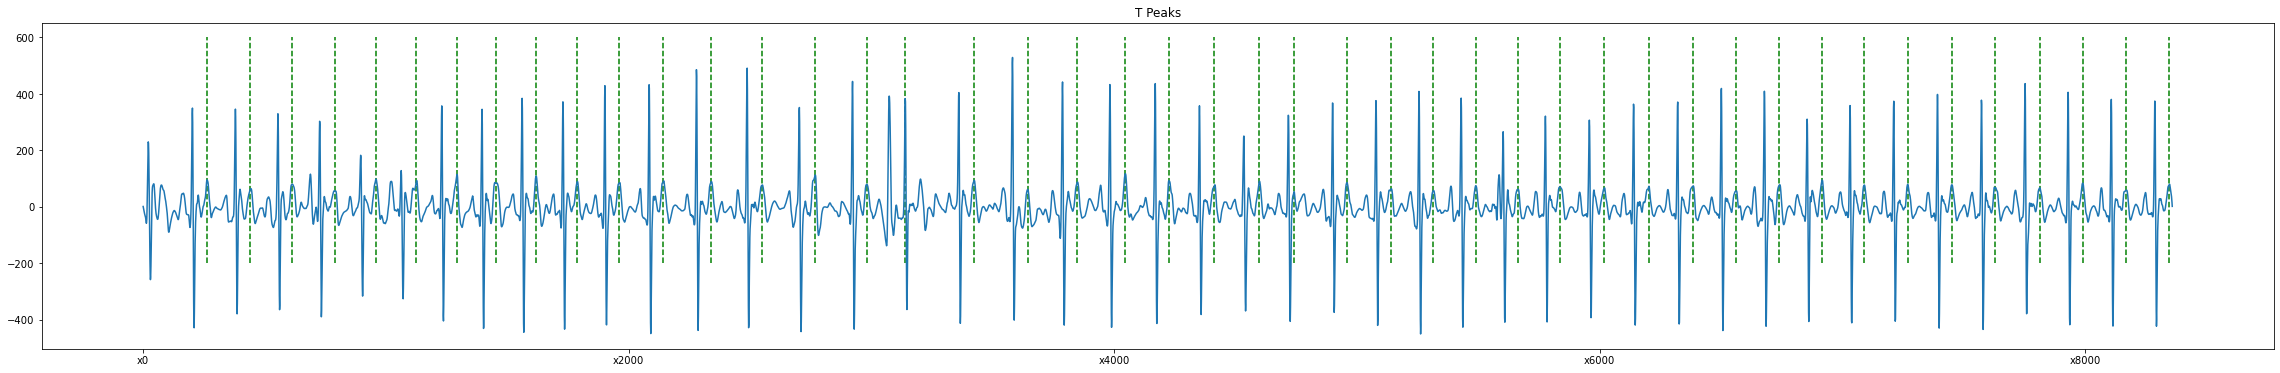

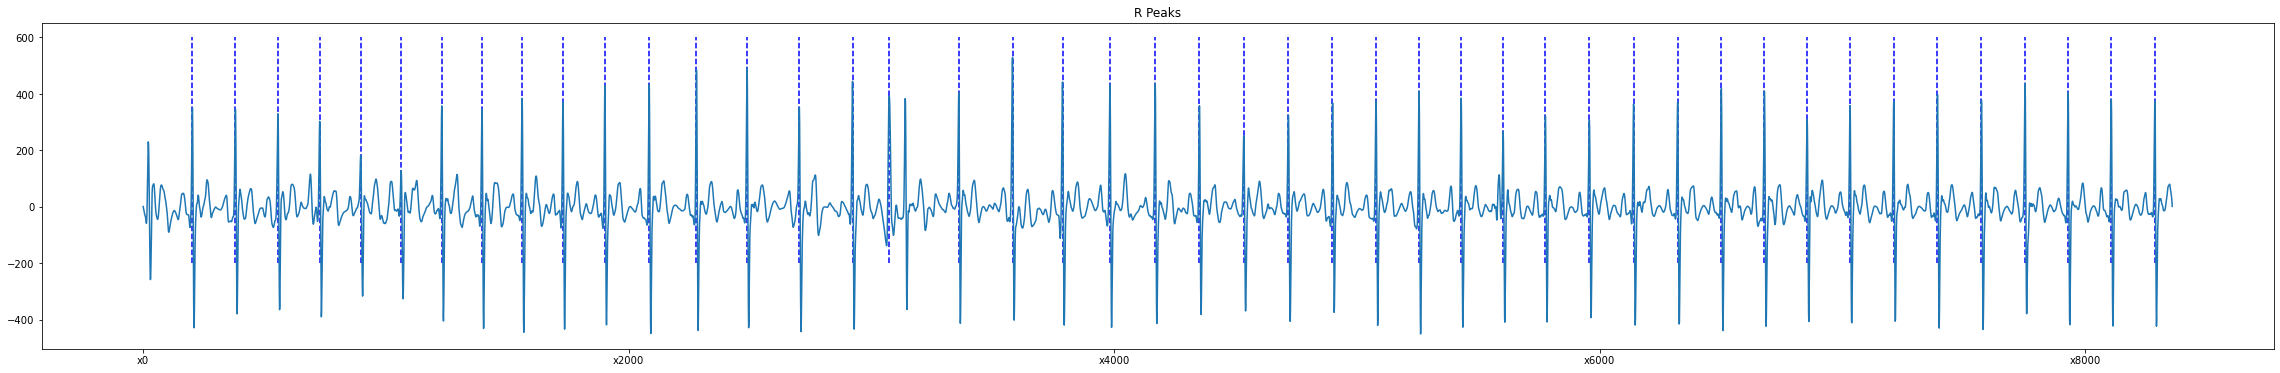

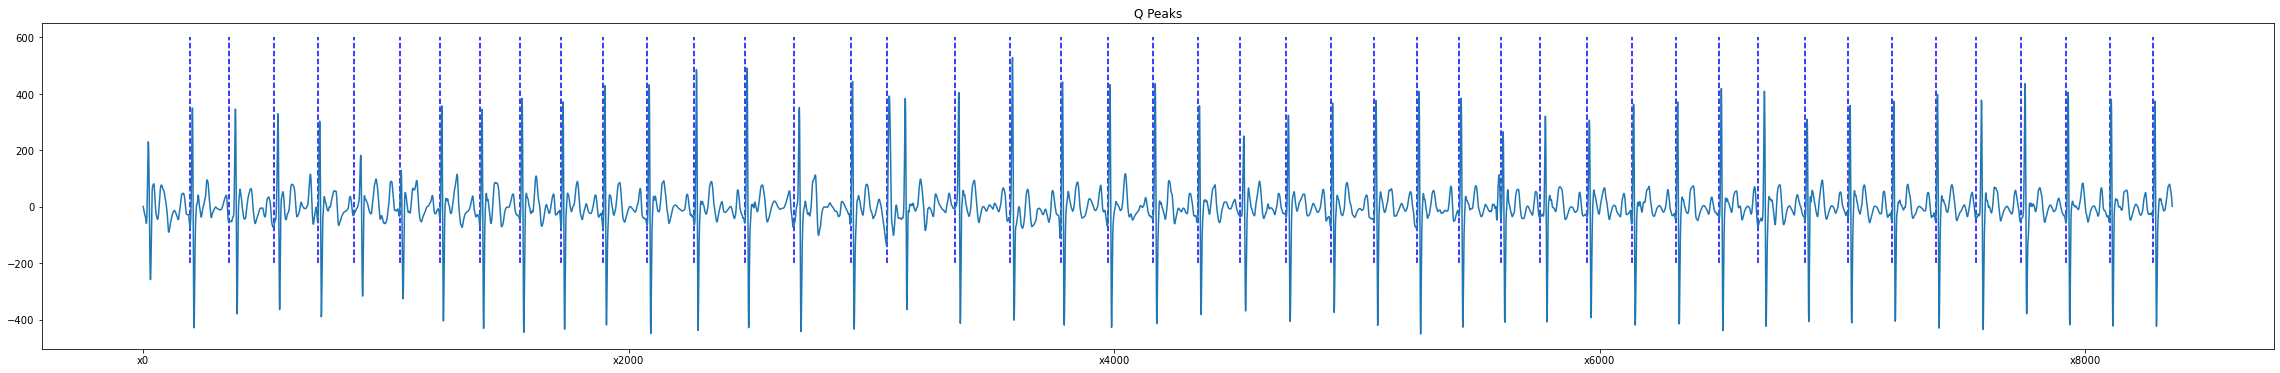

In [26]:
_, rpeaks = nk.ecg_peaks(signals.iloc[:,2], sampling_rate=300)
signal, wave = nk.ecg_delineate(signals.iloc[:,2], rpeaks, sampling_rate=300)


signals.iloc[:,2].plot(figsize=(40,6), title="P Peaks")
plt.vlines(wave["ECG_P_Peaks"], -200, 600, color='r',linestyles="dashed")
plt.show()
signals.iloc[:,2].plot(figsize=(40,6), title="T Peaks")
plt.vlines(wave["ECG_T_Peaks"], -200, 600, color='g',linestyles="dashed")
plt.show()
signals.iloc[:,2].plot(figsize=(40,6), title="R Peaks")
plt.vlines(rpeaks["ECG_R_Peaks"], -200, 600, color='b',linestyles="dashed")
plt.show()
signals.iloc[:,2].plot(figsize=(40,6), title="Q Peaks")
plt.vlines(wave["ECG_Q_Peaks"], -200, 600, color='b',linestyles="dashed")
plt.show()

In [27]:
rPeakIntervals = []
for i in range(0, len(rpeaks["ECG_R_Peaks"])-1):
    rPeakIntervals.append(rpeaks["ECG_R_Peaks"][i+1]-rpeaks["ECG_R_Peaks"][i])
rPeakIntervals = np.array(rPeakIntervals)
print(np.mean(rPeakIntervals))
print(np.std(rPeakIntervals))
print("No of R Peaks. ",len(rPeakIntervals))
print("No of P Peaks. ",len(wave["ECG_P_Peaks"]))
print("No of T Peaks. ",len(wave["ECG_T_Peaks"]))
print("No of Q Peaks. ",len(wave["ECG_Q_Peaks"]))

183.70454545454547
21.062223340998827
No of R Peaks.  44
No of P Peaks.  45
No of T Peaks.  45
No of Q Peaks.  45


In [109]:
for i in signals.columns:
    quality = nk.ecg_quality(signals[str(i)], sampling_rate=300,method="zhao2018")
    print(quality, " for ",str(i))
print("\n")
for i in signals.columns:
    quality = nk.ecg_quality(signals[str(i)], sampling_rate=300)
    meanq = np.array(quality).mean()
    print(meanq, " for ",str(i))

Barely acceptable  for  ECG_Raw
Unacceptable  for  ECG_NeuroKit
Barely acceptable  for  ECG_BioSPPy
Unacceptable  for  ECG_PanTompkins
Barely acceptable  for  ECG_Hamilton
Excellent  for  ECG_Elgendi
Barely acceptable  for  ECG_EngZeeMod


0.8020629676086969  for  ECG_Raw
0.8087463686383557  for  ECG_NeuroKit
0.8631547985772182  for  ECG_BioSPPy
0.8451153033804355  for  ECG_PanTompkins
0.8597137070375264  for  ECG_Hamilton
0.6790428781902603  for  ECG_Elgendi
0.8029802606369241  for  ECG_EngZeeMod


              Signal  Index Label
-0.313920 -80.677122    108     1
-0.310574 -74.943164    109     1
-0.307227 -69.688398    110     1
-0.303881 -64.944951    111     1
-0.300534 -60.374631    112     1
...              ...    ...   ...
 0.392214 -10.760343    319     1
 0.395561 -10.313000    320     1
 0.398907  -9.303159    321     1
 0.402254  -7.875646    322     1
 0.405601  -6.285923    323     1

[216 rows x 3 columns]


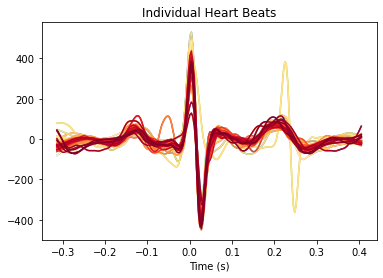

In [23]:
epochs = nk.ecg_segment(signals.iloc[:,2], rpeaks=rpeaks["ECG_R_Peaks"], sampling_rate=300, show=True)
print(epochs["1"])

# Idea : Fourier transformation of the data (Spectogram)

# Idea : Splitting samplings into smaller chunks using the peaks

# Idea : CNN can be useful!

# Idea : Extract features such as heart rate, presence of P waves (after QRS complex), the high-low of the peaks (axis deviation), and train a classifier on these features